In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- 1. Helper Function ---
def standardize_columns(df):
    new_cols = {}
    for col in df.columns:
        c_low = col.lower()
        if 'weighted' in c_low or 'wacc' in c_low:
            new_cols[col] = 'wacc_std' if 'std' in c_low else 'wacc_mean'
        elif 'accuracy' in c_low or 'acc' in c_low:
            new_cols[col] = 'acc_std' if 'std' in c_low else 'acc_mean'
        elif 'tau' in c_low or 'kendall' in c_low:
            new_cols[col] = 'tau_std' if 'std' in c_low else 'tau_mean'
    return df.rename(columns=new_cols)

# --- 2. Load Experimental Results ---
results_dir = Path("../results")
records = []

if results_dir.exists():
    for spammer_folder in results_dir.iterdir():
        if spammer_folder.is_dir():
            spammer_type = spammer_folder.name
            for csv_file in spammer_folder.glob("*.csv"):
                try:
                    df_temp = pd.read_csv(csv_file)
                    df_temp = standardize_columns(df_temp)
                    df_temp['SpammerType'] = spammer_type
                    df_temp['method'] = csv_file.stem 
                    records.append(df_temp)
                except Exception as e:
                    print(f"Error reading {csv_file}: {e}")

data = pd.concat(records, ignore_index=True) if records else pd.DataFrame()

# --- 3. Load and Inject Baseline (0% results) ---
baseline_csv_path = "../../../real_data/faceage/baselines_faceage.csv"
if Path(baseline_csv_path).exists():
    baseline_df = pd.read_csv(baseline_csv_path)
    baseline_df = standardize_columns(baseline_df)
    
    # Map "Simple BT" to "BT" (or however it appears in your method_order)
    baseline_df['method'] = baseline_df['Method'].replace({'Simple BT': 'BT'})
    baseline_df['percent'] = 0
    
    # Create a 0% entry for every SpammerType found in the results
    spammer_types = data['SpammerType'].unique()
    baseline_injections = []
    
    for stype in spammer_types:
        temp_baseline = baseline_df.copy()
        temp_baseline['SpammerType'] = stype
        baseline_injections.append(temp_baseline)
    
    # Merge baseline with experimental data
    data = pd.concat([pd.concat(baseline_injections)] + [data], ignore_index=True)
    
# Final cleaning
data['method'] = data['method'].str.strip().str.lower()
data = data.drop('Method', axis=1)
data = data.sort_values(["SpammerType", "percent", "method"]).reset_index(drop=True)

In [2]:
data

,acc_mean,acc_std,wacc_mean,wacc_std,tau_mean,tau_std,method,percent,SpammerType
0,0.791181,0.000000,0.872846,0.000000,0.577600,0.000000,barp,0,anti
1,0.790069,0.000000,0.871956,0.000000,0.575394,0.000000,bt,0,anti
2,0.790602,0.000202,0.872488,0.000132,0.576452,0.000401,crowdbt,0,anti
3,0.790487,0.000000,0.828528,0.000000,0.576224,0.000000,factorbt,0,anti
4,0.791560,0.000064,0.873164,0.000062,0.578352,0.000127,gradem,0,anti
...,...,...,...,...,...,...,...,...,...
205,0.790401,0.000226,0.872373,0.000165,0.576054,0.000448,crowdbt,80,right
206,0.782044,0.000095,0.822314,0.000118,0.559478,0.000188,factorbt,80,right
207,0.791476,0.000056,0.873096,0.000058,0.578185,0.000112,gradem,80,right
208,0.791495,0.000391,0.873050,0.000366,0.578222,0.000775,pgem,80,right


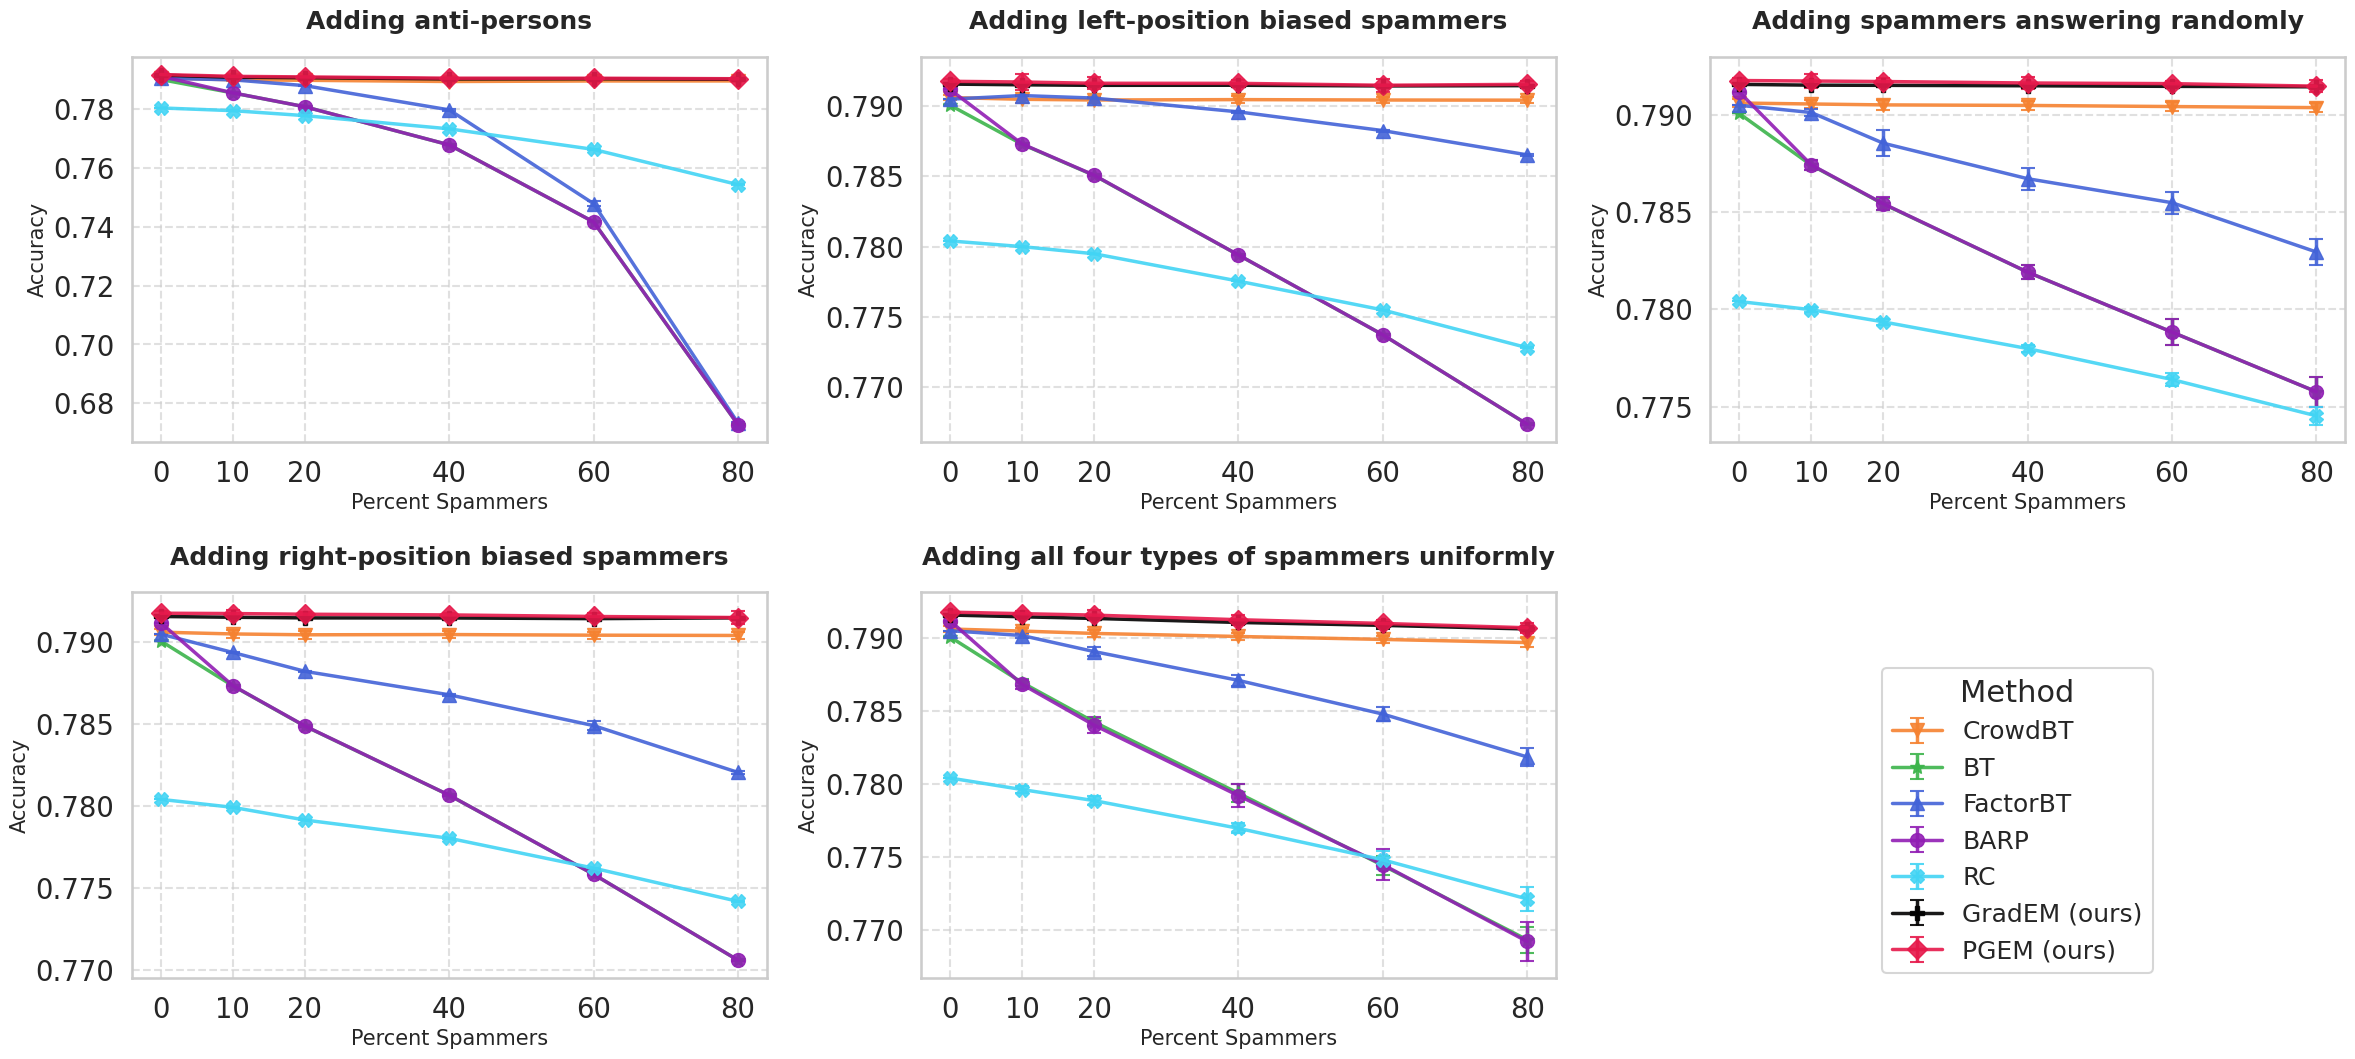

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Set the style
sns.set_theme(style="whitegrid", font_scale=1.2, context="talk")

# 2. Setup Variables and Reorder Spammer Types
all_types = list(data["SpammerType"].unique())
if "equal" in all_types:
    all_types.remove("equal")
    spammer_types = all_types + ["equal"]
else:
    spammer_types = all_types

# Descriptive Title Mapping
title_map = {
    "equal": "Adding all four types of spammers uniformly",
    "anti": "Adding anti-persons",
    "left": "Adding left-position biased spammers",
    "right": "Adding right-position biased spammers",
    "random": "Adding spammers answering randomly"
}

# Define parameters matching your requirements
method_order = ['CrowdBT', 'BT', 'FactorBT', 'BARP', 'RC', 'GradEM', 'PGEM']
colors = ["#F58231", "#3CB44B", "#4363D8", "#911EB4", "#42D4F4", "#010000", "#E6194B"]
markers = ['v', '*', '^', 'o', 'X', 'P', 'D']

# Create mapping dictionaries for the loop
color_map = dict(zip(method_order, colors))
marker_map = dict(zip(method_order, markers))

# 3. Create the Grid Plot
n_types = len(spammer_types)
n_cols = 3
n_rows = (n_types + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 6 * n_rows), squeeze=False)
axes = axes.flatten()

for i, stype in enumerate(spammer_types):
    ax = axes[i]
    subset = data[data["SpammerType"] == stype]
    
    # Use case-insensitive matching for methods present in the data
    available_methods_lower = subset["method"].str.lower().unique()
    for method in method_order:
        if method.lower() not in available_methods_lower:
            continue
            
        # Extract data for the method
        mdf = subset[subset["method"].str.lower() == method.lower()].sort_values("percent")
        color = color_map.get(method)
        marker = marker_map.get(method)
        
        # Plotting with error bars (since all have std dev)
        # Using .get() for std to avoid errors if a specific row is missing it
        ax.errorbar(
            mdf["percent"], mdf["acc_mean"], 
            yerr=mdf.get("acc_std", 0),
            label=method, 
            marker=marker, 
            markersize=10, 
            linewidth=2.5, 
            capsize=5, 
            capthick=1.5,
            color=color, 
            alpha=0.9
        )

    # Customize the subplot title
    display_title = title_map.get(stype, f"Effect of {stype.capitalize()} Spammers")
    ax.set_title(display_title, fontsize=18, fontweight='bold', pad=20)
    
    ax.set_xlabel("Percent Spammers", fontsize=15)
    ax.set_ylabel("Accuracy", fontsize=15)
    ax.set_xticks([0, 10, 20, 40, 60, 80])
    ax.grid(True, linestyle="--", alpha=0.6)

# 4. Global Legend Logic
# Extract handles/labels from the first axis that actually plotted something
handles, labels = axes[0].get_legend_handles_labels()

# Sort handles/labels to match your specified method_order exactly
label_to_handle = dict(zip(labels, handles))
ordered_handles = [label_to_handle[m] for m in method_order if m in label_to_handle]
ordered_labels = [m for m in method_order if m in label_to_handle]

updated_labels = []
for method in ordered_labels:
    if "EM" in method:
        method = method + " " + "(ours)"
    updated_labels.append(method)
# 1. Update legend position: loc='lower center', bbox_to_anchor=(0.5, -0.05)
fig.legend(ordered_handles, updated_labels, 
           loc='lower center', 
           bbox_to_anchor=(0.85, 0.16), # Adjust this to move it up/down
           ncol=1, 
           title="Method", 
           fontsize=18, 
           title_fontsize=22, 
           frameon=True)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 2. Update tight_layout: rect=[0, 0.12, 1, 1] 
# The 0.12 (bottom) creates room for the legend at the bottom
plt.tight_layout(rect=[0, 0.08, 1, 1])
# Save with high quality settings
plt.savefig(
    "spammer_analysis_faceage_acc.pdf", 
    format="pdf", 
    dpi=300,                # High resolution
    bbox_inches="tight",    # Removes extra whitespace around the plot
    transparent=True        # Useful if placing on a non-white background
)
plt.show()

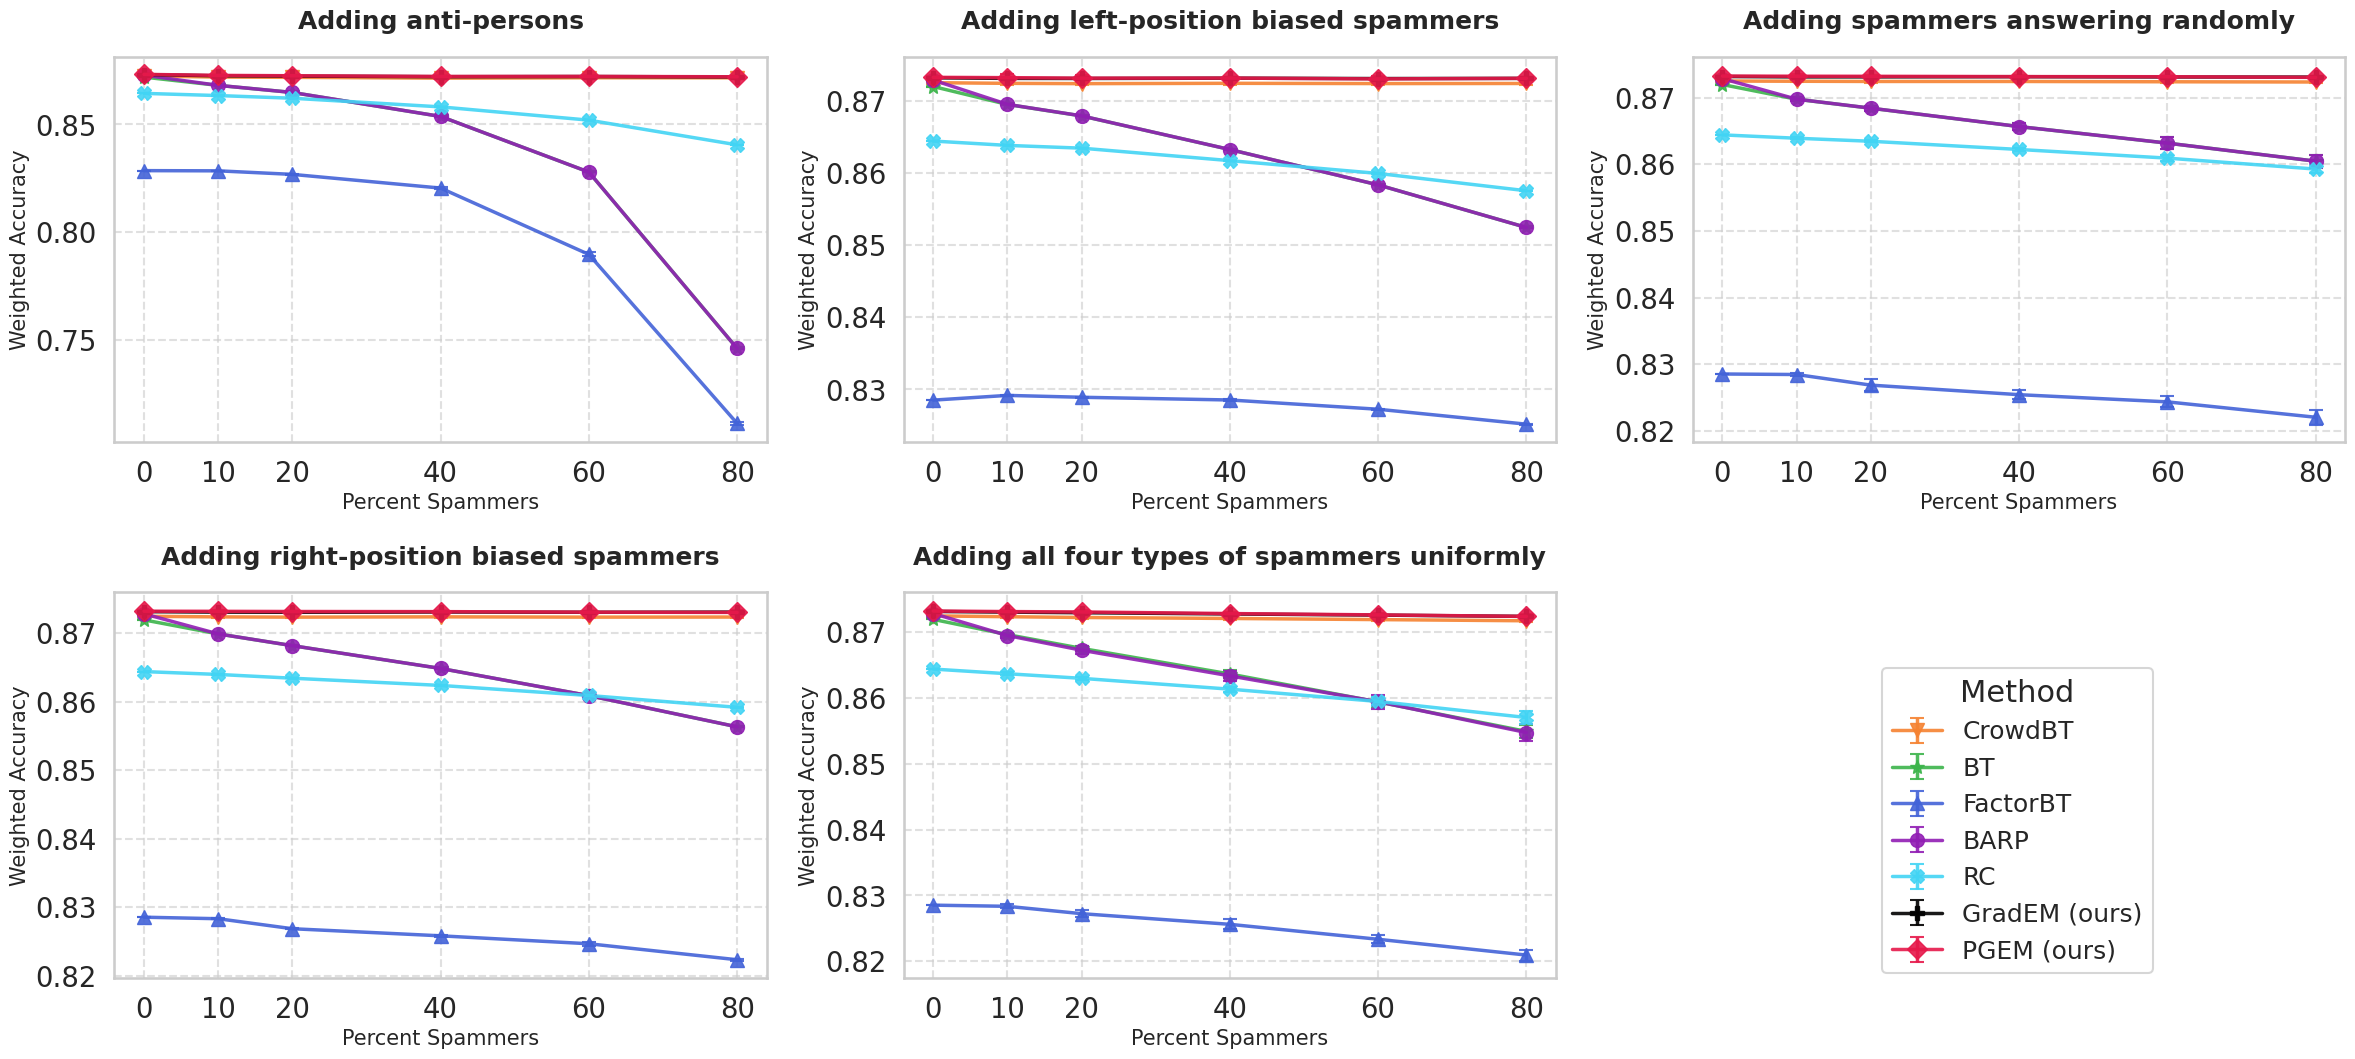

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Set the style
sns.set_theme(style="whitegrid", font_scale=1.2, context="talk")

# 2. Setup Variables and Reorder Spammer Types
all_types = list(data["SpammerType"].unique())
if "equal" in all_types:
    all_types.remove("equal")
    spammer_types = all_types + ["equal"]
else:
    spammer_types = all_types

# Descriptive Title Mapping
title_map = {
    "equal": "Adding all four types of spammers uniformly",
    "anti": "Adding anti-persons",
    "left": "Adding left-position biased spammers",
    "right": "Adding right-position biased spammers",
    "random": "Adding spammers answering randomly"
}

# Define parameters matching your requirements
method_order = ['CrowdBT', 'BT', 'FactorBT', 'BARP', 'RC', 'GradEM', 'PGEM']
colors = ["#F58231", "#3CB44B", "#4363D8", "#911EB4", "#42D4F4", "#010000", "#E6194B"]
markers = ['v', '*', '^', 'o', 'X', 'P', 'D']

# Create mapping dictionaries for the loop
color_map = dict(zip(method_order, colors))
marker_map = dict(zip(method_order, markers))

# 3. Create the Grid Plot
n_types = len(spammer_types)
n_cols = 3
n_rows = (n_types + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 6 * n_rows), squeeze=False)
axes = axes.flatten()

for i, stype in enumerate(spammer_types):
    ax = axes[i]
    subset = data[data["SpammerType"] == stype]
    
    # Use case-insensitive matching for methods present in the data
    available_methods_lower = subset["method"].str.lower().unique()

    for method in method_order:
        if method.lower() not in available_methods_lower:
            continue
            
        # Extract data for the method
        mdf = subset[subset["method"].str.lower() == method.lower()].sort_values("percent")
        color = color_map.get(method)
        marker = marker_map.get(method)
        
        # Plotting with error bars (since all have std dev)
        # Using .get() for std to avoid errors if a specific row is missing it
        ax.errorbar(
            mdf["percent"], mdf["wacc_mean"], 
            yerr=mdf.get("wacc_std", 0),
            label=method, 
            marker=marker, 
            markersize=10, 
            linewidth=2.5, 
            capsize=5, 
            capthick=1.5,
            color=color, 
            alpha=0.9
        )

    # Customize the subplot title
    display_title = title_map.get(stype, f"Effect of {stype.capitalize()} Spammers")
    ax.set_title(display_title, fontsize=18, fontweight='bold', pad=20)
    
    ax.set_xlabel("Percent Spammers", fontsize=15)
    ax.set_ylabel("Weighted Accuracy", fontsize=15)
    ax.set_xticks([0, 10, 20, 40, 60, 80])
    ax.grid(True, linestyle="--", alpha=0.6)

# 4. Global Legend Logic
# Extract handles/labels from the first axis that actually plotted something
handles, labels = axes[0].get_legend_handles_labels()

# Sort handles/labels to match your specified method_order exactly
label_to_handle = dict(zip(labels, handles))
ordered_handles = [label_to_handle[m] for m in method_order if m in label_to_handle]
ordered_labels = [m for m in method_order if m in label_to_handle]

updated_labels = []
for method in ordered_labels:
    if "EM" in method:
        method = method + " " + "(ours)"
    updated_labels.append(method)
# 1. Update legend position: loc='lower center', bbox_to_anchor=(0.5, -0.05)
fig.legend(ordered_handles, updated_labels, 
           loc='lower center', 
           bbox_to_anchor=(0.85, 0.16), # Adjust this to move it up/down
           ncol=1, 
           title="Method", 
           fontsize=18, 
           title_fontsize=22, 
           frameon=True)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 2. Update tight_layout: rect=[0, 0.12, 1, 1] 
# The 0.12 (bottom) creates room for the legend at the bottom
plt.tight_layout(rect=[0, 0.08, 1, 1])
# Save with high quality settings
plt.savefig(
    "spammer_analysis_faceage_wacc.pdf", 
    format="pdf", 
    dpi=300,                # High resolution
    bbox_inches="tight",    # Removes extra whitespace around the plot
    transparent=True        # Useful if placing on a non-white background
)
plt.show()

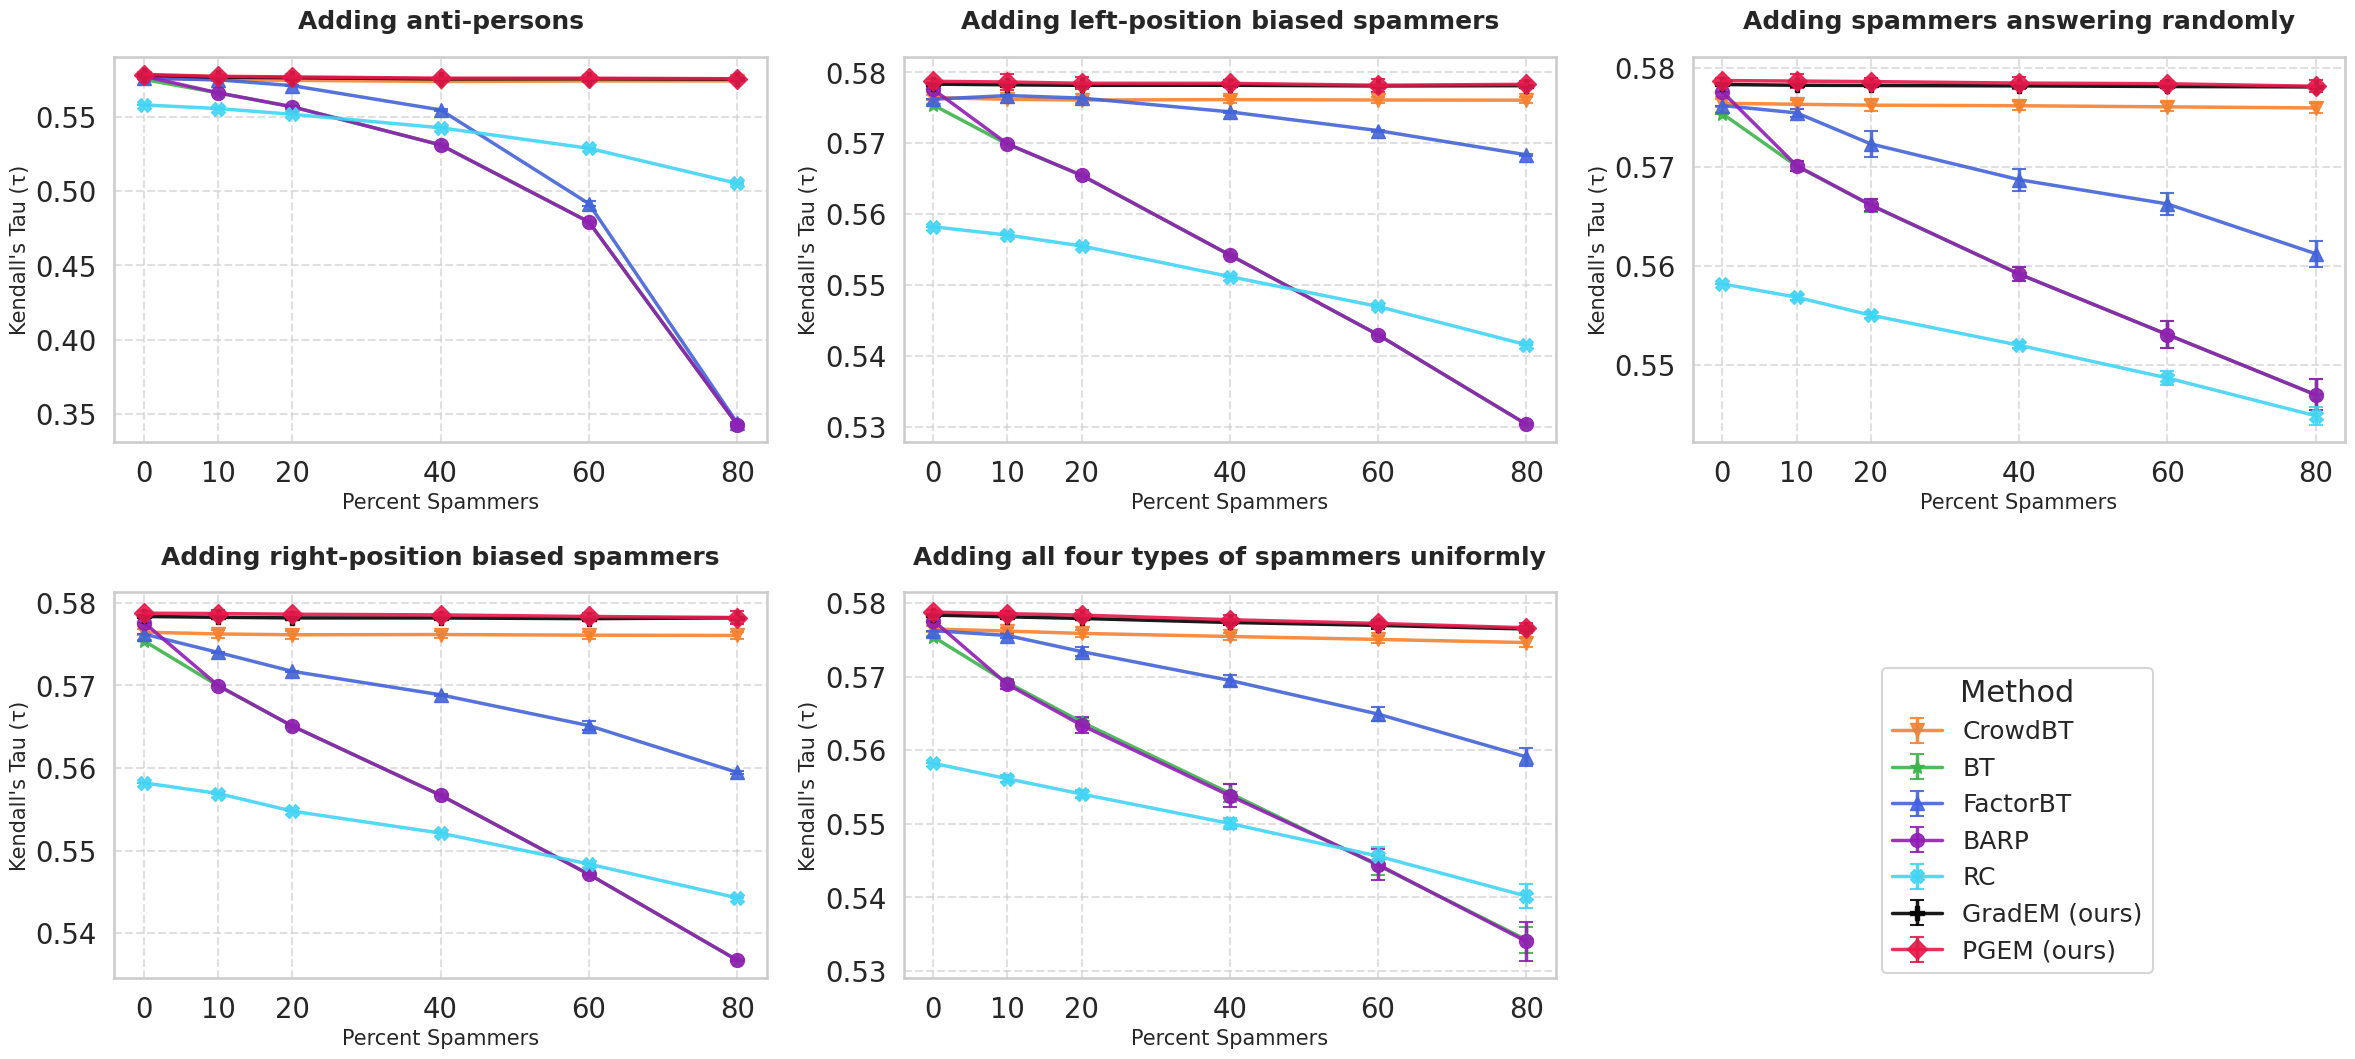

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Set the style
sns.set_theme(style="whitegrid", font_scale=1.2, context="talk")

# 2. Setup Variables and Reorder Spammer Types
all_types = list(data["SpammerType"].unique())
if "equal" in all_types:
    all_types.remove("equal")
    spammer_types = all_types + ["equal"]
else:
    spammer_types = all_types

# Descriptive Title Mapping
title_map = {
    "equal": "Adding all four types of spammers uniformly",
    "anti": "Adding anti-persons",
    "left": "Adding left-position biased spammers",
    "right": "Adding right-position biased spammers",
    "random": "Adding spammers answering randomly"
}

# Define parameters matching your requirements
method_order = ['CrowdBT', 'BT', 'FactorBT', 'BARP', 'RC', 'GradEM', 'PGEM']
colors = ["#F58231", "#3CB44B", "#4363D8", "#911EB4", "#42D4F4", "#010000", "#E6194B"]
markers = ['v', '*', '^', 'o', 'X', 'P', 'D']

# Create mapping dictionaries for the loop
color_map = dict(zip(method_order, colors))
marker_map = dict(zip(method_order, markers))

# 3. Create the Grid Plot
n_types = len(spammer_types)
n_cols = 3
n_rows = (n_types + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 6 * n_rows), squeeze=False)
axes = axes.flatten()

for i, stype in enumerate(spammer_types):
    ax = axes[i]
    subset = data[data["SpammerType"] == stype]
    
    # Use case-insensitive matching for methods present in the data
    available_methods_lower = subset["method"].str.lower().unique()

    for method in method_order:
        if method.lower() not in available_methods_lower:
            continue
            
        # Extract data for the method
        mdf = subset[subset["method"].str.lower() == method.lower()].sort_values("percent")
        color = color_map.get(method)
        marker = marker_map.get(method)
        
        # Plotting with error bars (since all have std dev)
        # Using .get() for std to avoid errors if a specific row is missing it
        ax.errorbar(
            mdf["percent"], mdf["tau_mean"], 
            yerr=mdf.get("tau_std", 0),
            label=method, 
            marker=marker, 
            markersize=10, 
            linewidth=2.5, 
            capsize=5, 
            capthick=1.5,
            color=color, 
            alpha=0.9
        )

    # Customize the subplot title
    display_title = title_map.get(stype, f"Effect of {stype.capitalize()} Spammers")
    ax.set_title(display_title, fontsize=18, fontweight='bold', pad=20)
    
    ax.set_xlabel("Percent Spammers", fontsize=15)
    ax.set_ylabel("Kendall's Tau (τ)", fontsize=15)
    ax.set_xticks([0, 10, 20, 40, 60, 80])
    ax.grid(True, linestyle="--", alpha=0.6)

# 4. Global Legend Logic
# Extract handles/labels from the first axis that actually plotted something
handles, labels = axes[0].get_legend_handles_labels()

# Sort handles/labels to match your specified method_order exactly
label_to_handle = dict(zip(labels, handles))
ordered_handles = [label_to_handle[m] for m in method_order if m in label_to_handle]
ordered_labels = [m for m in method_order if m in label_to_handle]

updated_labels = []
for method in ordered_labels:
    if "EM" in method:
        method = method + " " + "(ours)"
    updated_labels.append(method)
# 1. Update legend position: loc='lower center', bbox_to_anchor=(0.5, -0.05)
fig.legend(ordered_handles, updated_labels, 
           loc='lower center', 
           bbox_to_anchor=(0.85, 0.16), # Adjust this to move it up/down
           ncol=1, 
           title="Method", 
           fontsize=18, 
           title_fontsize=22, 
           frameon=True)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 2. Update tight_layout: rect=[0, 0.12, 1, 1] 
# The 0.12 (bottom) creates room for the legend at the bottom
plt.tight_layout(rect=[0, 0.08, 1, 1])
# Save with high quality settings
plt.savefig(
    "spammer_analysis_faceage_tau.pdf", 
    format="pdf", 
    dpi=300,                # High resolution
    bbox_inches="tight",    # Removes extra whitespace around the plot
    transparent=True        # Useful if placing on a non-white background
)
plt.show()